In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras import layers, utils, backend, callbacks

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import modplot
import numpy as np
import pandas as pd

from hep_ml import reweight

import uproot

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

2024-02-20 22:21:25.672217: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 22:21:26.054707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 22:21:27.567742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-20 22:21:31.023011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 22:21:31.039782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 22:21:31.039831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## ZFit 
Returns weights for centrality 0, 1 or 2 (0-10,10-40,40-80 %)

Important : (D0mass > 1.75) & (D0mass<2.0) cuts should be always applied


In [2]:
import mplhep
import numpy as np
import zfit
from matplotlib import pyplot as plt
import uproot
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(1.75, 2.0))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)


def getSWeights(centrality) -> np.array:
    centralityCut=""
    if (centrality ==0):
        centralityCut = "(centrality==8)"
    elif (centrality ==1):
        centralityCut = "(centrality>=5) &( centrality<8) "
    elif (centrality ==2):
        centralityCut = "(centrality <5)"
    else:
        print("Wrong centrality")
        return

    with uproot.open("/home/prozorov/dev/star/D0_jets_2014_231030.root") as exp_file:
          exp_tree = exp_file['Jets']
          exp = exp_tree.arrays(["D0mass"], cut=centralityCut + " & (D0mass > 1.75) & (D0mass<2.0)",library='pd')
    
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights


/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2024-02-20 22:21:31.645415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 22:21:31.645521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 22:21:31.645543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [3]:

with uproot.open("~/dev/star/unfold/JetFinderEfficiency.root") as fileEff:
    fileEff.classnames()
    JetFinderEfficiency=fileEff["JetFinderEfficiency"].to_numpy()
    print(JetFinderEfficiency[1])
    print(JetFinderEfficiency[0])

def getEfficiencyPtWeight(pt):
    ptBin = np.digitize(pt, JetFinderEfficiency[1])-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(JetFinderEfficiency[0])):
        ptBin=len(JetFinderEfficiency[0])-1
    return JetFinderEfficiency[0][ptBin]


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 15. 18. 30.]
[[0.8040493  0.83887934 0.91436481]
 [0.83531431 0.87066498 0.93592894]
 [0.86378964 0.89502397 0.94950428]
 [0.8858829  0.91200534 0.95879075]
 [0.90171456 0.92392761 0.96557282]
 [0.91389318 0.93324831 0.97033296]
 [0.92173535 0.94047693 0.97348525]
 [0.92743685 0.94662845 0.97777634]
 [0.93525452 0.94907014 0.97975429]
 [0.94756974 0.95762499 0.98211105]
 [0.95040946 0.96266307 0.98382422]
 [0.96602388 0.96608892 0.98780008]
 [0.96862745 0.96307934 0.99102773]]


In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
#@keras.saving.register_keras_serializable(package="CustomModel", name="DNN2")
class DNN(keras.Model):
    def __init__(self, sizes=(100, 100, 100), outputDims=2, inputDims=None, **kwargs):
        super().__init__(**kwargs)
        self._outputShape=outputDims
        self._denseSizes=sizes
        self._inputShape=inputShape

        self._inputs = keras.Input(shape=inputDims)
        self._layers = []
        for i, size in enumerate(sizes):
            _layer = layers.Dense(size, kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.L1L2(l2=1e-4))
            _activation = layers.Activation("relu")
            self._layers.extend([_layer, _activation])

        _layer = layers.Dense(outputDims)
        _activation = layers.Activation("softmax")
        self._layers.extend([_layer, _activation])

        self._outputs = self.call(self._inputs)
        self._model = keras.Model(self._inputs, self._outputs)

    def call(self, inputs):
        self._tensors = [inputs]
        for _layer in self._layers:
            tensor = _layer(self._tensors[-1])
            self._tensors.append(tensor)
        return self._tensors[-1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "sizes": self._denseSizes,
            "outputDims": self._outputShape,
            "inputDims": self._inputShape,
        })
        return config

    def model(self):
        return self._model

In [6]:
trees = [uproot.open("/home/prozorov/dev/star/output_jets.root:Jets"), ]

trees[0].keys()


['Centrality',
 'Weight',
 'RefMult',
 'gRefMult',
 'RefCorr2',
 'McRefMult',
 'RecoRefMult',
 'McD0Pt',
 'McD0Eta',
 'McD0Phi',
 'McPionPt',
 'McPionEta',
 'McPionPhi',
 'McKaonPt',
 'McKaonEta',
 'McKaonPhi',
 'RecoD0Pt',
 'RecoD0Eta',
 'RecoD0Phi',
 'RecoPionPt',
 'RecoPionEta',
 'RecoPionPhi',
 'RecoKaonPt',
 'RecoKaonEta',
 'RecoKaonPhi',
 'McJetPt',
 'McJetEta',
 'McJetPhi',
 'McJetArea',
 'McJetE',
 'McJetNConst',
 'McJetLambda_1_1',
 'McJetLambda_1_1half',
 'McJetLambda_1_2',
 'McJetLambda_1_3',
 'McJetD0Z',
 'McRecoJetPt',
 'McRecoJetEta',
 'McRecoJetPhi',
 'McRecoJetE',
 'McRecoJetArea',
 'McRecoJetNConst',
 'McRecoJetLambda_1_1',
 'McRecoJetLambda_1_1half',
 'McRecoJetLambda_1_2',
 'McRecoJetLambda_1_3',
 'McRecoJetD0Z',
 'RecoJetPt',
 'RecoJetEta',
 'RecoJetPhi',
 'RecoJetArea',
 'RecoJetE',
 'RecoJetRhoVal',
 'RecoJetNConst',
 'RecoJetLambda_1_1',
 'RecoJetLambda_1_1half',
 'RecoJetLambda_1_2',
 'RecoJetLambda_1_3',
 'RecoJetD0Z']

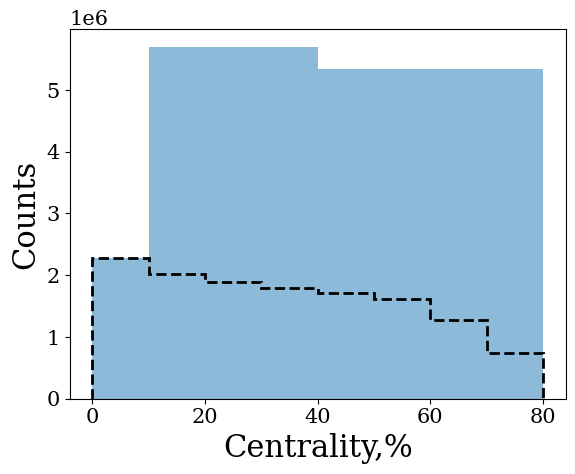

In [7]:
centrality=trees[0]["Centrality"].array()
plt.hist(centrality, bins=np.linspace(0, 80, 9), **plot_style_0)
plt.xlabel("Centrality,%")
plt.ylabel("Counts")

centralityBins=[0,10,40,80]
plt.hist(centrality, bins=centralityBins, **plot_style_2)
plt.show()

centralityCuts = ["(Centrality > {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]



In [8]:
columns = ["pt", "z", "lambda_1_1", "lambda_1_1half", "lambda_1_2", "lambda_1_3"]

with uproot.open("/home/prozorov/dev/star/output_jets.root") as original_file:
    original_tree = original_file['Jets']
    sim = original_tree.arrays(["RecoJetPt","RecoJetD0Z","RecoJetLambda_1_1",
                            "RecoJetLambda_1_1half","RecoJetLambda_1_2",
                            "RecoJetLambda_1_3"], cut="(RecoJetNConst>0) & (Centrality<10)", library='pd', entry_stop=1000000)
    
    sim.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z",  "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3"}, inplace=True)
    
with uproot.open("/home/prozorov/dev/star/D0_jets_2014_231030.root") as target_file:
    target_tree = target_file['Jets']
    exp = target_tree.arrays(["jet_pt_corr","z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], cut="centrality==8",library='pd')
    exp.rename(columns={"jet_pt_corr": "pt"}, inplace=True)

original_weights = np.ones(len(sim))

# divide original samples into training ant test parts
original_train, original_test = train_test_split(sim)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(exp)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))

from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 50, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [1, 99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.yscale('log')
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

In [9]:
draw_distributions(original, target, original_weights)



NameError: name 'original' is not defined

In [ ]:
draw_distributions(original_train, target_train, original_weights_train)



In [ ]:
draw_distributions(original_test, target_test, original_weights_test)

In [ ]:


# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=100, 
                                        learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                        gb_args={'subsample': 0.4})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=3)
# it is not needed divide data into train/test parts; reweighter can be train on the whole samples
reweighter.fit(original, target)

folding_weights  = reweighter.predict_weights(original)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original, target, folding_weights)



In [ ]:
plt.hist(gb_weights_test, bins=50)
plt.yscale('log')
plt.title('predicted weights')

In [ ]:

trees = [uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")]
centralityBins=[0,80]
centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]
nEvents=100000

features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3"]

# make centrality dependent analysis

for i in range(len(centralityCuts)):
  print("Processing centrality bin: ", centralityCuts[i])
  
  sim_mc_reco= trees[0].arrays(["McJetPt", "McJetD0Z", 
                               "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3", 
                              "RecoJetPt","RecoJetD0Z",
                               "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetNConst"
                            ],   
                              cut=centralityCuts[i], library="pd", entry_stop=nEvents)
        
  genJets = sim_mc_reco.iloc[:,0:6]
  recoJets = sim_mc_reco.iloc[:,6:13]
  genJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3"}, inplace=True)
  recoJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3"}, inplace=True)

  dummyval=-99
  mask = recoJets["RecoJetNConst"] == 0
  recoJets.loc[mask,features[0]:features[-1]] = dummyval

  print(recoJets.head(20))
  print(genJets.head(20))

  trainGen, testGen, trainReco, testReco = train_test_split(genJets, recoJets, test_size=0.2)

  trainWts = np.ones(trainGen.shape[0])
  print("Sum of training weights: ", trainWts.sum())

  testWts = np.ones(testGen.shape[0])
  print("Sum of testing weights: ", testWts.sum())

  scaler = StandardScaler()

  X_det = scaler.fit_transform(pd.concat([testReco[features], trainReco[features]], ignore_index=True, sort=False))
  X_gen = scaler.fit_transform(pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False))

  Y_det = utils.to_categorical(np.concatenate( (np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0])) ))
  Y_gen = utils.to_categorical(np.concatenate( (np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0])) ))

  print("detector-level input shapes: ", X_det.shape, Y_det.shape)
  print("generator-level input shapes: ", X_gen.shape, Y_gen.shape)


  print("X_det.head(): ", X_det[0:5])



In [ ]:
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
#wtest[key] = np.ones(ntest[key])
wData = testWts
#wtrain[key] = ntest[key]/ntrain[key]*np.ones(ntrain[key])
wEmbedding = (testWts.sum()/trainWts.sum()*trainWts)

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

folderPath = "./weights/savedModel_"

lossFunc="binary_crossentropy"
optimizer="adam"
metricList=["accuracy"]

validationSize = 0.2
nEpochs = 50
batchSize = 1000

inputShape = X_det.shape[1:]

w_sim = [wEmbedding]
nIter = 2
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)




# reweight the sim and data to have the same total weight to begin with
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])

#wData = np.ones(nData)
#wEmbedding = nData/float(nEmbedding)*np.ones(nEmbedding)

wData = testWts.to_numpy()
wEmbedding = (np.sum(wData)/trainWts.sum()*trainWts).to_numpy()

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

plt.hist(trainGen["pt"], bins=30, weights=wEmbedding)
plt.hist(trainReco["pt"], bins=30, weights=wEmbedding)

plt.yscale("log")

now = datetime.now()
nownow = now.strftime("%d-%m-%Y_%H-%M-%S")
folderPath = "savedModels/savedModel_"+nownow
unfoldingWeightsFilename = f"{folderPath}/unfoldingWeights"
#logdir = "logs/"+nownow

lossFunc="categorical_crossentropy"
optimizer="adam"
metricList=["accuracy"]
#weightedMetricList = ["categorical_crossentropy"]
weightedMetricList = []

patience=5

validationSize = 0.2
nEpochs = 150
batchSize = 2048

inputShape = X_det.shape[1:]

det_history = []
gen_history = []
w_sim = [wEmbedding]
nIter = 10

weightClipMin = 0.
weightClipMax = np.inf







for i in range(nIter):
    detModel = sequentialDNNMaker(input_shape=inputShape)
    detModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
    detCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
    detModelFilePath = folderPath + f"/step1_iteration{i}"+"_epoch{epoch}"
    detCallBacks.append(callbacks.ModelCheckpoint(detModelFilePath, save_best_only=True, verbose=1))
    #detCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

    genModel = sequentialDNNMaker(input_shape=inputShape)
    genModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
    genCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
    genModelFilePath = folderPath + f"/step2_iteration{i}"+"_epoch{epoch}"
    genCallBacks.append(callbacks.ModelCheckpoint(genModelFilePath, save_best_only=True, verbose=1))
    #genCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

    if(i > 0):
        detModel.load_weights(folderPath + f"/step1_iteration{i-1}")
        genModel.load_weights(folderPath + f"/step2_iteration{i-1}")

    w_det = np.concatenate([wData, w_sim[-1]])
    
    X_det_train, X_det_val, Y_det_train, Y_det_val, w_det_train, w_det_val = train_test_split(X_det, Y_det, w_det, test_size=validationSize)
    detModel.summary()
    det_history.append(detModel.fit(X_det_train, Y_det_train, sample_weight=w_det_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_det_val, Y_det_val, w_det_val), verbose=1, callbacks=detCallBacks))
    detModel.save_weights(folderPath + f"/step1_iteration{i}")
    
    prediction = detModel.predict(X_det, batch_size=batchSize*10)
    scaleFactors = prediction[Y_det[:, 0] == 1]

    _pull = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
    w_sim.append(_pull)

    w_gen = np.concatenate([w_sim[-1], w_sim[-2]])
    
    X_gen_train, X_gen_val, Y_gen_train, Y_gen_val, w_gen_train, w_gen_val = train_test_split(X_gen, Y_gen, w_gen, test_size=validationSize)
    genModel.summary()
    gen_history.append(genModel.fit(X_gen_train, Y_gen_train, sample_weight=w_gen_train, epochs=nEpochs, batch_size=5*batchSize, validation_data=(X_gen_val, Y_gen_val, w_gen_val), verbose=1, callbacks=genCallBacks))
    genModel.save_weights(folderPath + f"/step2_iteration{i}")
    
    prediction = genModel.predict(X_gen, batch_size=batchSize*50)
    scaleFactors = prediction[Y_gen[:, 0] == 1]

    _push = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
    w_sim.append(_push)
    
    np.save(unfoldingWeightsFilename, w_sim)

#filename = f"outputs/multifoldClosure_{patience}_{batchSize}_{nEpochs}_{nIter}_{nownow}.root"
#outFile = uproot.recreate(filename)
#print("Saving to file: ", filename)

#trainGen["wt"] = w_sim[2*nIter]
#outFile["unfolded"] = trainGen
#outFile["reco"] = testReco
#outFile["gen"] = testGen
wu=w_sim

### Plot Style

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})

In [ ]:
# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (-1, 30),  'ylim': (0.00000001, 0.3),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.425, 0.65),
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0.1, 1.001),   'ylim': (0, 10),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.8),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.4),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.2),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.1),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

In [ ]:
for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]



    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
  
   
    print('Done with', obkey)


In [ ]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])


    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)


    ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='``Gen\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Truth.', **hist_style)


    # # plot the "gen" histogram of the observable
    # ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=w_sim[-1],
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

    of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
    ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)

    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 2, 0, 1] if ncol==2 else [3, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{test}'
)


    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()

In [ ]:
_iter = 6
nRows = 3
nColumns = 3
fig, ax = plt.subplots(nRows, nColumns, figsize=(30., 30.))
for i, feature in enumerate(featuresNoWt):
    row = int(i/nColumns)
    column = i%nColumns 
        
    histGen, bins = np.histogram(testGen[feature], weights=wData, density=True)
    histReco, bins = np.histogram(testReco[feature], weights=wData, density=True) 
    histUnfolded, bins = np.histogram(trainGen[feature], weights=wu[2*_iter], density=True)
        
    ax[row, column].hist(bins[:-1], bins, weights=histReco/histGen, label="Reco/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=histUnfolded/histGen, label="Unfolded/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=np.ones((bins.shape[0]-1)), histtype="step")
    ax[row, column].set_title(feature)
    ax[row, column].set_ylim(0.5, 1.5)
    ax[row, column].legend(prop={'size': 15})
        

In [ ]:
_nIter = 10

#metrics = ["loss", "accuracy", "categorical_crossentropy"]
metrics = ["loss", "accuracy"]
detfig, detax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        detax[row, column].plot(det_history[column].history[metricName], label="training")
        detax[row, column].plot(det_history[column].history["val_"+metricName], label="validation")
        detax[row, column].set_title(metricName+f", detector level, iteration={column+1}")
        #detax[row, column].set_ylim(0.25, 0.32)
        detax[row, column].legend()

In [ ]:
genfig, genax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        genax[row, column].plot(gen_history[column].history[metricName], label="training")
        genax[row, column].plot(gen_history[column].history["val_"+metricName], label="validation")
        genax[row, column].set_title(metricName+f", gen level, iteration={column+1}")
        genax[row, column].legend()

In [ ]:
print(det_history[0].history)